In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats

%matplotlib inline

**Data is not available for download - needed to create a scraping function to get the data I need for the dataset**

In [2]:
def scrape_baseball_savant(year):
    '''
    Takes in year to scrape Statcast hitting stats from MLBs Baseball Savant website. 
    Data only available for 2015 to 2022 seasons. 
    
    Input
    year - int: year that you want stats for
    
    Output
    batting_stats - dataframe: dataframe converted to csv with scraped data
    
    '''
    
    if year < 2015 or year > 2022:
        print("Invalid year, stats only available from 2015 to 2022.")
        
    else:
    
        url = 'https://baseballsavant.mlb.com/league?season='+str(year)+'#statcastHitting'
        page = requests.get(url)
        
        soup = BeautifulSoup(page.text, 'lxml')
        
        table = soup.find('table')
        
        columns = []
        for i in table.find_all('th'):
            title = i.text
            columns.append(title)
            
        headers = columns[3:]
        
        data_frame = pd.DataFrame(columns = headers)
        
        for r in table.find_all('tr')[2:]:
            row_data = r.find_all('td')
            row = [i.text for i in row_data]
            length = len(data_frame)
            data_frame.loc[length] = row
            
        save_file = 'batting_' + str(year) + '.csv'
        
        data_frame.to_csv(save_file, index = False)


**Pulling the data for all years available 2015 to 2022**

In [3]:
seasons = [2015,2016,2017,2018,2019,2020,2021,2022]
for season in seasons:
    scrape_baseball_savant(season)

### Creating and cleaning for the master dataset. Not all stats are needed/relevant to hypothesis

**Quick exploration to see what needs to be cleaned/fixed. Will go off the 2022 dataset and then create a function for the rest.**

In [4]:
# check that I can pull a dataset based on a year
year = 2022
test = 'batting_' + str(year) + '.csv'

test_df = pd.read_csv(test)

In [5]:
test_df.columns

Index(['Team', 'Season', 'PA', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'BA',
       'OBP', 'SLG', 'WOBA', 'WOBACON', 'Pitches', 'Batted Balls', 'Barrels',
       'Barrel %', 'Hard Hit %', 'Exit Velocity', 'Launch Angle', 'XBA',
       'XSLG', 'XWOBA', 'XWOBACON'],
      dtype='object')

In [6]:
test_df.head()

,Team,Season,PA,AB,H,2B,3B,HR,BB,SO,...,Batted Balls,Barrels,Barrel %,Hard Hit %,Exit Velocity,Launch Angle,XBA,XSLG,XWOBA,XWOBACON
0,Yankees,2022,6172,5422,1308,225,8,254,620,1391,...,4086,411,10.1,41.9,89.7,13.3,0.244,0.427,0.330,0.385
1,White Sox,2022,6123,5611,1435,272,9,149,388,1269,...,4393,329,7.5,40.8,89.2,10.6,0.248,0.395,0.308,0.358
2,Braves,2022,6082,5509,1394,298,11,243,470,1498,...,4048,441,10.9,43.5,89.9,13.5,0.248,0.445,0.331,0.407
3,Red Sox,2022,6144,5539,1427,352,12,155,478,1373,...,4228,343,8.1,40.9,89.3,11.4,0.250,0.402,0.316,0.373
4,Blue Jays,2022,6158,5555,1464,307,12,200,500,1242,...,4354,368,8.5,44.3,90.2,11.2,0.257,0.418,0.326,0.374


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Team           31 non-null     object 
 1   Season         31 non-null     int64  
 2   PA             31 non-null     int64  
 3   AB             31 non-null     int64  
 4   H              31 non-null     int64  
 5   2B             31 non-null     int64  
 6   3B             31 non-null     int64  
 7   HR             31 non-null     int64  
 8   BB             31 non-null     int64  
 9   SO             31 non-null     int64  
 10  BA             31 non-null     float64
 11  OBP            31 non-null     float64
 12  SLG            31 non-null     float64
 13  WOBA           31 non-null     float64
 14  WOBACON        31 non-null     float64
 15  Pitches        31 non-null     int64  
 16  Batted Balls   31 non-null     int64  
 17  Barrels        31 non-null     int64  
 18  Barrel %    

In [8]:
test_df.columns

Index(['Team', 'Season', 'PA', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'BA',
       'OBP', 'SLG', 'WOBA', 'WOBACON', 'Pitches', 'Batted Balls', 'Barrels',
       'Barrel %', 'Hard Hit %', 'Exit Velocity', 'Launch Angle', 'XBA',
       'XSLG', 'XWOBA', 'XWOBACON'],
      dtype='object')

In [9]:
# dropping all columns but team, season, batted balls and hard hit%
expected_drops = ['XBA', 'XSLG', 'XWOBA', 'XWOBACON','Barrels', 'Barrel %', 'Exit Velocity', 'Launch Angle',
                  'PA', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'BA',
                 'OBP', 'SLG', 'WOBA', 'WOBACON', 'Pitches']
test_df.drop(expected_drops, axis = 1, inplace = True)

In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Team          31 non-null     object 
 1   Season        31 non-null     int64  
 2   Batted Balls  31 non-null     int64  
 3   Hard Hit %    31 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.1+ KB


In [11]:
# only 30 MLB teams, the extra row is for season totals that I won't need. 
test_df.drop(30, inplace=True)

In [12]:
#changing column name for Batted Balls and Hard Hit % so I can use with dot notation
test_df.rename(columns={'Hard Hit %': 'HardHitPerc', 'Batted Balls': 'BattedBalls'}, inplace = True)

In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Team         30 non-null     object 
 1   Season       30 non-null     int64  
 2   BattedBalls  30 non-null     int64  
 3   HardHitPerc  30 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.1+ KB


**I'll need to add the runs scored from a separate dataset to the dataframes since that wasn't included with the Baseball Savant data.**

In [14]:
runs_df = pd.read_csv('runs_scored.csv')

In [15]:
runs_df.head()

,Season,Team,R
0,2015,ARI,720
1,2016,ARI,752
2,2017,ARI,812
3,2018,ARI,693
4,2019,ARI,813


In [16]:
runs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Season  210 non-null    int64 
 1   Team    210 non-null    object
 2   R       210 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 5.0+ KB


In [17]:
# check the team abbreviations in the runs data set
runs_df.Team.unique()

array(['ARI', 'ATL', 'BAL', 'BOS', 'CHC', 'CHW', 'CIN', 'CLE', 'COL',
       'DET', 'HOU', 'KCR', 'LAA', 'LAD', 'MIA', 'MIL', 'MIN', 'NYM',
       'NYY', 'OAK', 'PHI', 'PIT', 'SDP', 'SEA', 'SFG', 'STL', 'TBR',
       'TEX', 'TOR', 'WSN'], dtype=object)

In [18]:
# check the team names in the batting dataset
# it appears that there are leading whitespaces for each team name
test_df.Team.unique()

array(['  Yankees', '  White Sox', '  Braves', '  Red Sox', '  Blue Jays',
       '  Astros', '  Athletics', '  Brewers', '  Rays', '  Padres',
       '  Reds', '  Twins', '  Giants', '  Mariners', '  Marlins',
       '  Nationals', '  Rangers', '  Cardinals', '  D-backs',
       '  Orioles', '  Tigers', '  Mets', '  Pirates', '  Phillies',
       '  Guardians', '  Angels', '  Dodgers', '  Cubs', '  Rockies',
       '  Royals'], dtype=object)

In [19]:
# remove the leading white space from team names
test_df.Team = test_df.Team.apply(lambda x: x.strip())

In [20]:
# create a team name map so I can match the Team column in the runs dataset to the batting datasets 
team_map = {'LAD' : 'Dodgers', 'BOS': 'Red Sox', 'SFG' : 'Giants', 'HOU' : 'Astros', 'NYY':'Yankees', 
            'CHC':'Cubs', 'CLE':'Guardians', 'NYM':'Mets', 'ATL':'Braves',
           'MIN':'Twins', 'TBR':'Rays', 'STL':'Cardinals', 'PIT':'Pirates', 
            'OAK':'Athletics', 'WSN':'Nationals', 'MIL':'Brewers', 'TEX':'Rangers', 'KCR':'Royals',
           'CHW':'White Sox', 'ARI':'D-backs', 'TOR': 'Blue Jays', 'COL': 'Rockies', 'SEA':'Mariners', 
            'SDP':'Padres', 'BAL':'Orioles', 'PHI':'Phillies', 'DET':'Tigers',
           'LAA':'Angels', 'CIN':'Reds', 'MIA':'Marlins'}

In [21]:
# change team names
runs_df.Team = runs_df.Team.map(team_map)

In [22]:
runs_df.head()

,Season,Team,R
0,2015,D-backs,720
1,2016,D-backs,752
2,2017,D-backs,812
3,2018,D-backs,693
4,2019,D-backs,813


**Now I'll put together the two datasets to make sure they are working correctly.**

In [23]:
# get the run totals from Runs dataframe
join_df = test_df.merge(runs_df, how = 'inner', on = ['Season', 'Team'])

In [24]:
join_df.head()

,Team,Season,BattedBalls,HardHitPerc,R
0,Yankees,2022,4086,41.9,807
1,White Sox,2022,4393,40.8,686
2,Braves,2022,4048,43.5,789
3,Red Sox,2022,4228,40.9,735
4,Blue Jays,2022,4354,44.3,775


In [25]:
join_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Team         30 non-null     object 
 1   Season       30 non-null     int64  
 2   BattedBalls  30 non-null     int64  
 3   HardHitPerc  30 non-null     float64
 4   R            30 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.4+ KB


**Write the cleaning and combining function for the remainding seasons.**

In [26]:
def clean_and_combine(years):
    
    '''
    Takes a list of seasons and creates a master dataframe that is cleaned and combined with total Runs included.
    
    Data is only available from 2015-2022. 
    
    Inputs
    years - list: list of seasons you want to combine into the master dataframe. 
    
    Outputs
    master_dataframe - df: a cleaned and comprehensive dataframe with runs scored added and formatting errors fixed. 
    
    
    '''
    headers = ['Team', 'Season', 'BattedBalls', 'HardHitPerc']
    
    master_frame = pd.DataFrame(columns = headers)
    
    for year in years:
        
        # getting file name
        file = 'batting_' + str(year) + '.csv'
        
        # read in file
        df = pd.read_csv(file)
        
        # make drops 
        expected_drops = ['XBA', 'XSLG', 'XWOBA', 'XWOBACON','Barrels', 'Barrel %', 'Exit Velocity', 'Launch Angle',
                 'PA', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'BA',
                 'OBP', 'SLG', 'WOBA', 'WOBACON', 'Pitches']
        df.drop(expected_drops, axis = 1, inplace = True)
        
        # make name changes to columns
        df.rename(columns={'Hard Hit %': 'HardHitPerc', 'Batted Balls': 'BattedBalls'}, inplace = True)
        
        # remove leading whitespace from team names
        df.Team = df.Team.apply(lambda x: x.strip())
        
        # drop total row
        df.drop(30, inplace = True)
        
        # add year dataframe to master dataframe
        master_frame = pd.concat([master_frame, df])
        
        
    # set up runs dataframe with correct team names
    # read in runs csv
    run_df = pd.read_csv('runs_scored.csv')
        
    # change team names in runs dataset    
    team_map = {'LAD' : 'Dodgers', 'BOS': 'Red Sox', 'SFG' : 'Giants', 'HOU' : 'Astros', 'NYY':'Yankees', 
            'CHC':'Cubs', 'CLE':'Guardians', 'NYM':'Mets', 'ATL':'Braves',
           'MIN':'Twins', 'TBR':'Rays', 'STL':'Cardinals', 'PIT':'Pirates', 
            'OAK':'Athletics', 'WSN':'Nationals', 'MIL':'Brewers', 'TEX':'Rangers', 'KCR':'Royals',
           'CHW':'White Sox', 'ARI':'D-backs', 'TOR': 'Blue Jays', 'COL': 'Rockies', 'SEA':'Mariners', 
            'SDP':'Padres', 'BAL':'Orioles', 'PHI':'Phillies', 'DET':'Tigers',
           'LAA':'Angels', 'CIN':'Reds', 'MIA':'Marlins'}
        
    run_df.Team = run_df.Team.map(team_map)
    
    # add runs to master dataframe
    master_frame = master_frame.merge(run_df, how = 'inner', on = ['Season', 'Team'])
    
    
    return master_frame
    

In [27]:
# 2020 shortened season due to Covid-19 pandemic - only 60 games vs 162, excluded from analysis
seasons = [2015,2016,2017,2018,2019,2021,2022]
full_df = clean_and_combine(seasons)

In [41]:
full_df.to_csv('master_dataframe.csv', index=False)

**Exploratory analysis. Check that all the seasons were loaded correctly. Fix any issues with merge.**
**Make sure data is distributed normally and that there are no extreme outliers in any columns.**

In [28]:
full_df.head()

,Team,Season,BattedBalls,HardHitPerc,R
0,Nationals,2015,4190,37.5,703
1,Blue Jays,2015,4457,36.7,891
2,Mets,2015,4298,34.7,683
3,Braves,2015,4411,29.4,573
4,Yankees,2015,4418,34.3,764


In [29]:
full_df.Season.unique()

array([2015, 2016, 2017, 2018, 2019, 2021, 2022], dtype=object)

In [30]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210 entries, 0 to 209
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Team         210 non-null    object 
 1   Season       210 non-null    object 
 2   BattedBalls  210 non-null    object 
 3   HardHitPerc  210 non-null    float64
 4   R            210 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 9.8+ KB


**Batted balls was changed to an object data type during the merge. Need to switch them back to integers.**

In [31]:
data_changes = ['BattedBalls']

for col in data_changes:
    full_df[col] = full_df[col].astype('int64')

In [32]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210 entries, 0 to 209
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Team         210 non-null    object 
 1   Season       210 non-null    object 
 2   BattedBalls  210 non-null    int64  
 3   HardHitPerc  210 non-null    float64
 4   R            210 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 9.8+ KB


In [33]:
#check that teams all have the same number of occurences 
full_df.Team.value_counts()

Nationals    7
Blue Jays    7
Rockies      7
D-backs      7
Athletics    7
Twins        7
Royals       7
Marlins      7
Giants       7
Cardinals    7
Phillies     7
Padres       7
Brewers      7
Red Sox      7
Rangers      7
Rays         7
Cubs         7
Guardians    7
Reds         7
Pirates      7
White Sox    7
Dodgers      7
Astros       7
Mariners     7
Angels       7
Orioles      7
Yankees      7
Braves       7
Mets         7
Tigers       7
Name: Team, dtype: int64

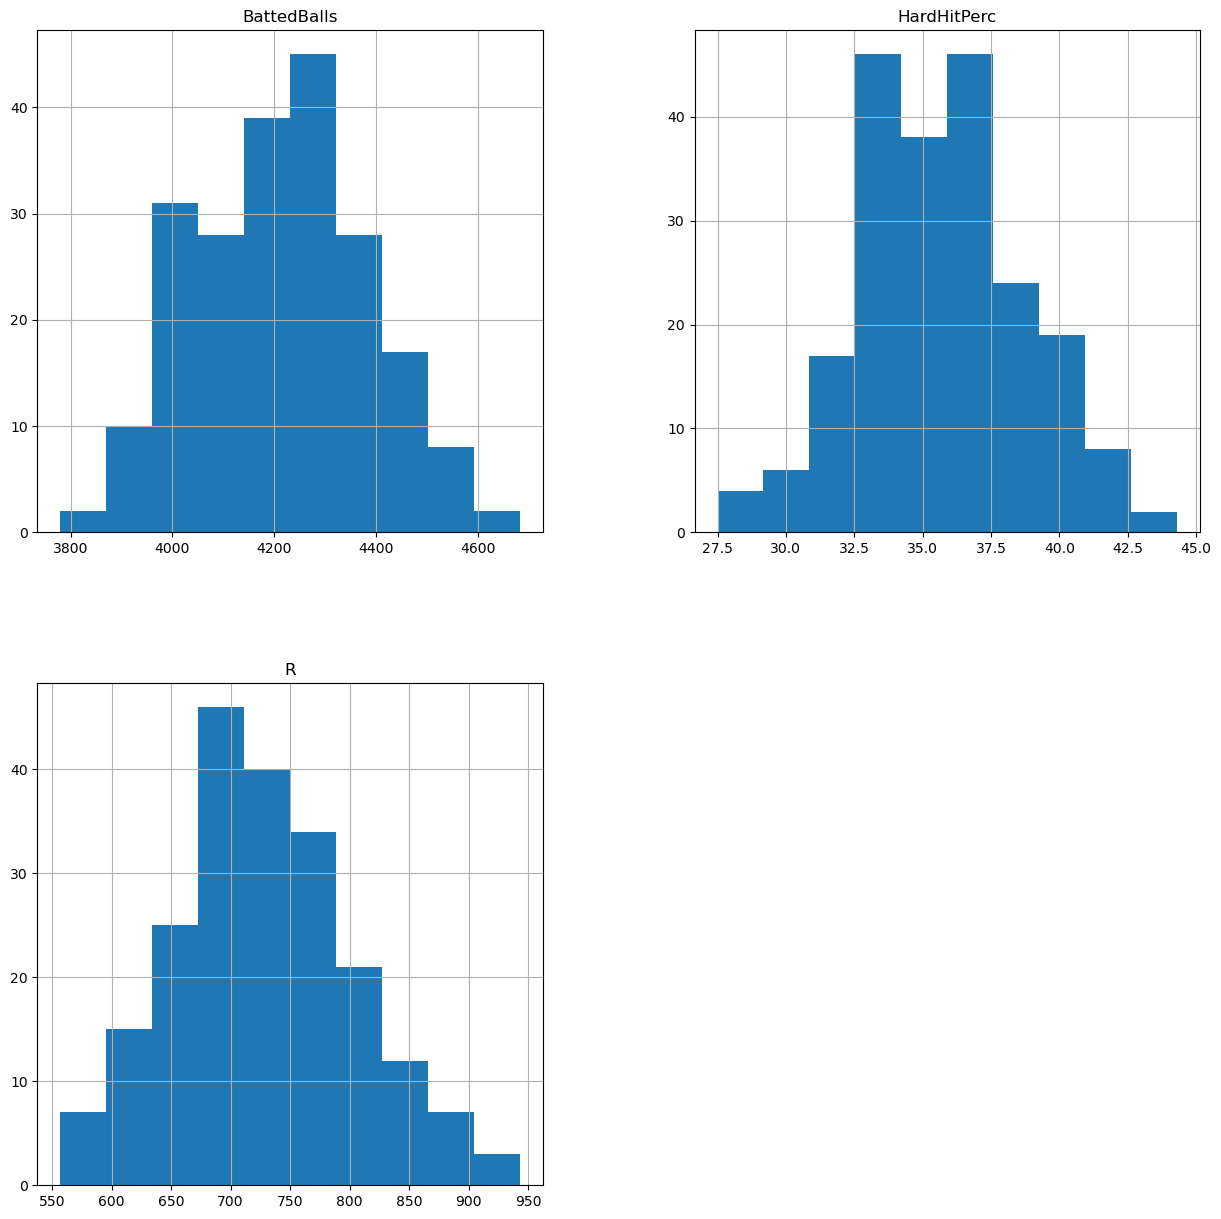

In [34]:
# check data distributions
full_df.hist(figsize=(15,15));

In [35]:
full_df.describe()

,BattedBalls,HardHitPerc,R
count,210.000000,210.000000,210.000000
mean,4213.638095,35.753333,728.080952
std,169.664664,3.079398,76.090403
min,3780.000000,27.500000,557.000000
25%,4080.750000,33.525000,678.250000
50%,4219.000000,35.750000,724.000000
75%,4332.000000,37.650000,771.750000
max,4683.000000,44.300000,943.000000


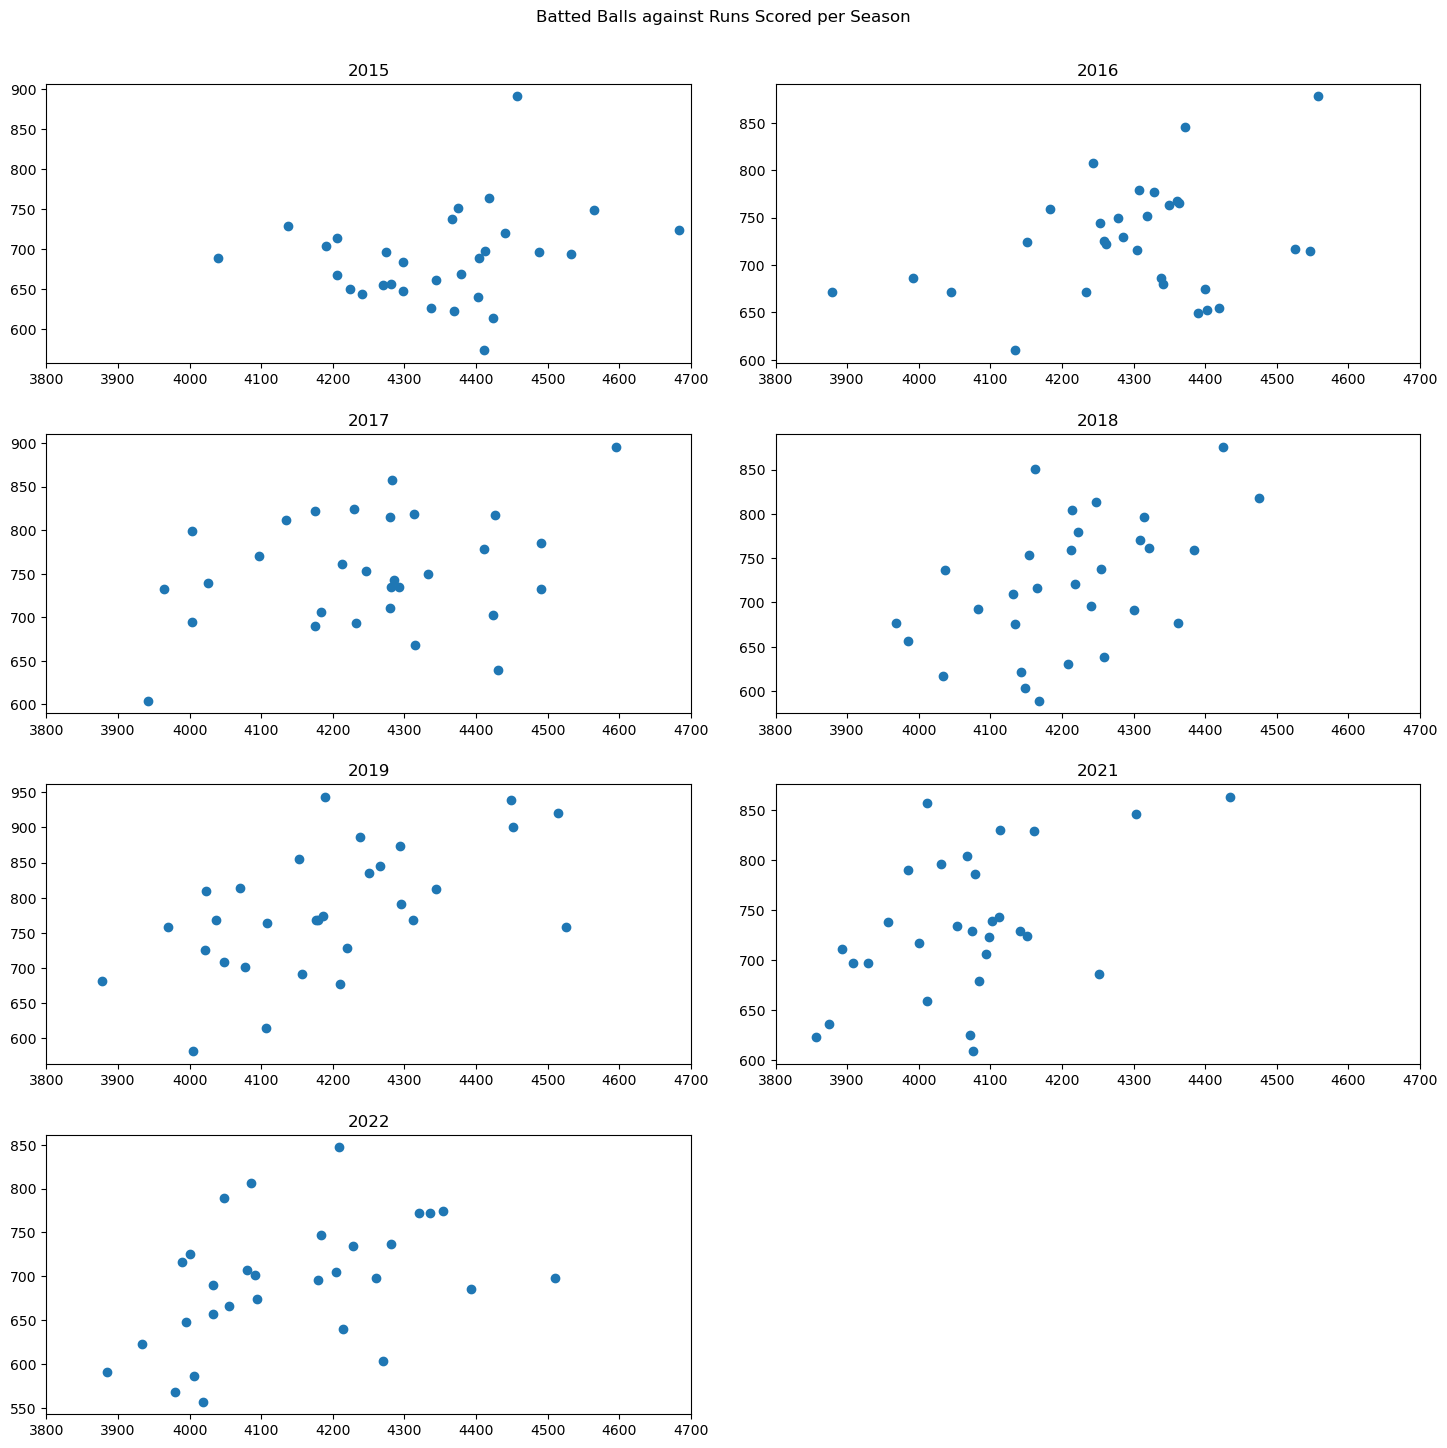

In [36]:
fig, axs = plt.subplots(4, 2, figsize=(15,15))
fig.suptitle('Batted Balls against Runs Scored per Season')
fig.tight_layout(pad = 3)
custom_limit = (3800, 4700)
plt.setp(axs, xlim = custom_limit)

axs[0,0].set_title('2015')
axs[0,0].scatter(x = full_df.query('Season == 2015').BattedBalls, y = full_df.query('Season == 2015').R);

axs[0,1].set_title('2016')
axs[0,1].scatter(x = full_df.query('Season == 2016').BattedBalls, y = full_df.query('Season == 2016').R);

axs[1,0].set_title('2017')
axs[1,0].scatter(x = full_df.query('Season == 2017').BattedBalls, y = full_df.query('Season == 2017').R);

axs[1,1].set_title('2018')
axs[1,1].scatter(x = full_df.query('Season == 2018').BattedBalls, y = full_df.query('Season == 2018').R);

axs[2,0].set_title('2019')
axs[2,0].scatter(x = full_df.query('Season == 2019').BattedBalls, y = full_df.query('Season == 2019').R);

axs[2,1].set_title('2021')
axs[2,1].scatter(x = full_df.query('Season == 2021').BattedBalls, y = full_df.query('Season == 2021').R);

axs[3,0].set_title('2022')
axs[3,0].scatter(x = full_df.query('Season == 2022').BattedBalls, y = full_df.query('Season == 2022').R);

axs[3,1].axis('off');

**Run a linear regression for each year to get a model for batted balls against runs scored**

In [37]:
full_df['Intercept'] = 1

In [38]:
models = []

for year in seasons:
    model = sm.OLS(full_df.query('Season == @year').R, full_df.query('Season == @year')[['BattedBalls', 'Intercept']])
    result = model.fit()
    models.append(result.params)
    print(str(year) + ' Season')
    print(result.summary())
    print('\n')

2015 Season
                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.323
Date:                Wed, 12 Apr 2023   Prob (F-statistic):              0.260
Time:                        18:47:27   Log-Likelihood:                -163.57
No. Observations:                  30   AIC:                             331.1
Df Residuals:                      28   BIC:                             333.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
BattedBalls     0.0938      0.082     

In [39]:
def regression_variables(year):
    """
    Function used to clean up code in plotting. Uses scipy stats linear regression model. 
    
    Input
    
    year - int: year you want get linear regression model values for
    
    Output
    
    slope - float: slope of linear regression model
    intercept - float: intercept value of linear regression model
    r - float: r value of linear regression model
    p - float: p value of linear regression model
    stderr - float: standard deviation of linear regression model
    
    """
    
    slope, intercept, r, p, stderr = scipy.stats.linregress(
        full_df.query('Season == @year').BattedBalls, full_df.query('Season == @year').R)
    
    return slope, intercept, r, p, stderr
    

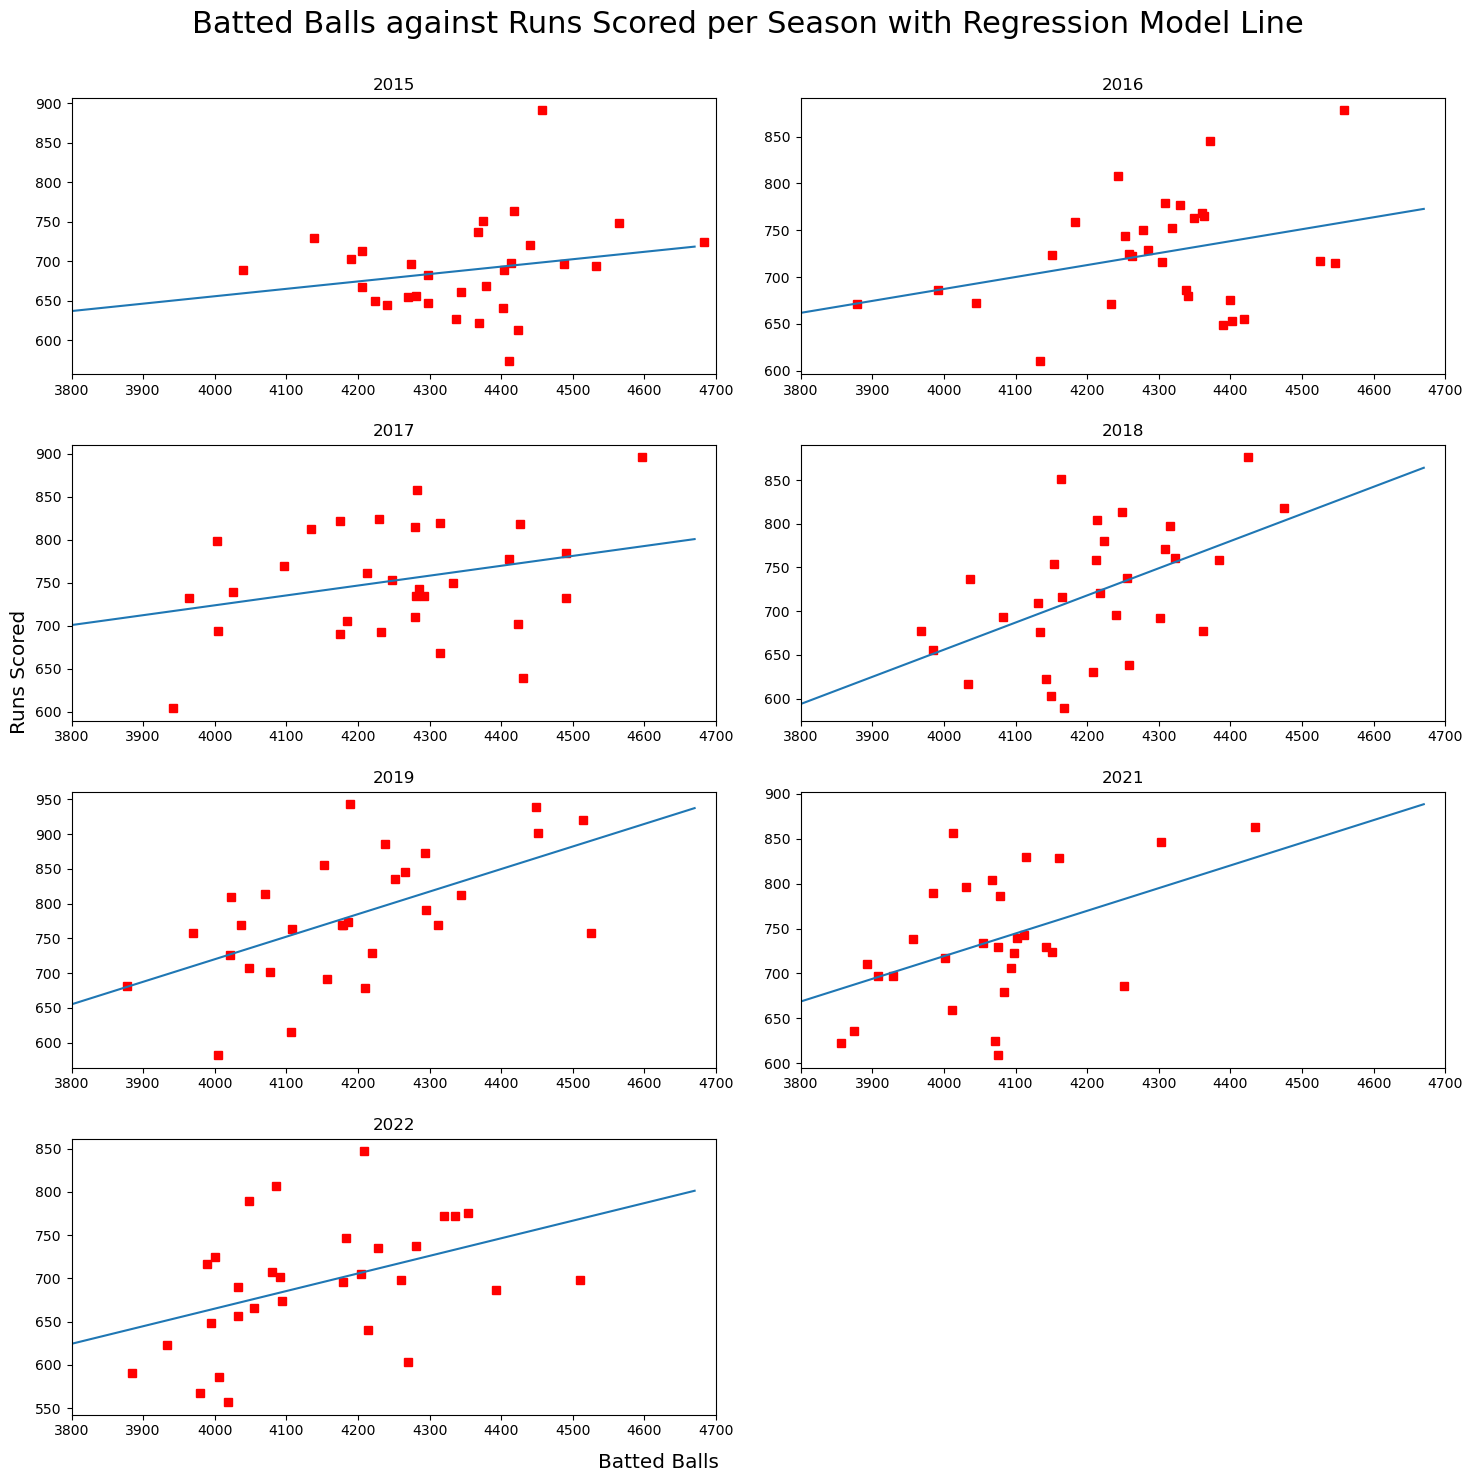

In [40]:
fig, axs = plt.subplots(4, 2, figsize=(15,15))
fig.suptitle('Batted Balls against Runs Scored per Season with Regression Model Line', fontsize = 22)
fig.tight_layout(pad = 3)
x = np.array(list(range(3800,4700,30)))
fig.text(0.4, 0.008, 'Batted Balls', fontsize='x-large')
fig.text(0.008, 0.5, 'Runs Scored', fontsize='x-large', rotation='vertical')



axs[0,0].set_title('2015')
axs[0,0].set_xlim([3800, 4700])
slope, intercept, r, p, stderr = regression_variables(2015)
axs[0,0].plot(full_df.query('Season == 2015').BattedBalls, 
              full_df.query('Season == 2015').R, linewidth = 0, marker ='s', color = 'red');
axs[0,0].plot(x, intercept + slope * x)

axs[0,1].set_title('2016')
axs[0,1].set_xlim([3800, 4700])
slope, intercept, r, p, stderr = regression_variables(2016)
axs[0,1].plot(full_df.query('Season == 2016').BattedBalls, 
              full_df.query('Season == 2016').R, linewidth = 0, marker ='s', color = 'red');
axs[0,1].plot(x, intercept + slope * x)


axs[1,0].set_title('2017')
axs[1,0].set_xlim([3800, 4700])
slope, intercept, r, p, stderr = regression_variables(2017)
axs[1,0].plot(full_df.query('Season == 2017').BattedBalls, 
              full_df.query('Season == 2017').R, linewidth = 0, marker ='s', color = 'red');
axs[1,0].plot(x, intercept + slope * x)


axs[1,1].set_title('2018')
axs[1,1].set_xlim([3800, 4700])
slope, intercept, r, p, stderr = regression_variables(2018)
axs[1,1].plot(full_df.query('Season == 2018').BattedBalls, 
              full_df.query('Season == 2018').R, linewidth = 0, marker ='s', color = 'red');
axs[1,1].plot(x, intercept + slope * x)


axs[2,0].set_title('2019')
axs[2,0].set_xlim([3800, 4700])
slope, intercept, r, p, stderr = regression_variables(2019)
axs[2,0].plot(full_df.query('Season == 2019').BattedBalls, 
              full_df.query('Season == 2019').R, linewidth = 0, marker ='s', color = 'red');
axs[2,0].plot(x, intercept + slope * x)


axs[2,1].set_title('2021')
axs[2,1].set_xlim([3800, 4700])
slope, intercept, r, p, stderr = regression_variables(2021)
axs[2,1].plot(full_df.query('Season == 2021').BattedBalls, 
              full_df.query('Season == 2021').R, linewidth = 0, marker ='s', color = 'red');
axs[2,1].plot(x, intercept + slope * x)


axs[3,0].set_title('2022')
axs[3,0].set_xlim([3800, 4700])
slope, intercept, r, p, stderr = regression_variables(2022)
axs[3,0].plot(full_df.query('Season == 2022').BattedBalls, 
              full_df.query('Season == 2022').R, linewidth = 0, marker ='s', color = 'red');
axs[3,0].plot(x, intercept + slope * x)



axs[3,1].axis('off');